# Working with GOSIF data
[GOSIF](https://doi.org/10.3390/rs11050517) is a science data product generated by Dr. Jingfeng Xiao's group that estimates SIF with global coverage at 0.05° (~6km/pixel) resolution on an 8-day cadence. The estimates of SIF are derived from a data-based approach that combines data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instruments onboard the Terra and Aqua spacecraft with OCO-2 SIF measurements and MERRA-2 meteorological model data. MODIS data from Terra and Aqua are an invaluable resource for climate analysis because they provide a 25-year record of daily global coverage imaging across 36 spectral bands. The researchers combined these data with OCO-2 SIF soundings and MERRA-2 model outputs to train a Cubist regression tree model that can predict SIF for a MODIS 0.05° grid. Importantly, GOSIF is able to provide these predictions from 2000 up to the present (although data is presently available up to 2023), meaning it includes a 14-year period before OCO-2 even launched. 

In this exercise, we will download and view SIF data, then compare its accuracy with direct SIF soundings from OCO-2 or OCO-3. Afterwards, we will see how GOSIF can be used in analysis.

In [1]:
from http.server import HTTPServer, SimpleHTTPRequestHandler
from IPython.display import HTML, IFrame
import os
import random
from rasterstats import zonal_stats
import socket
import shutil
import sys
from tqdm.notebook import tqdm
import threading

# Add src directory containing helper code to sys.path
sys.path.append(os.path.abspath("../src"))

from pysif import convert_geotiff_to_png, create_gosif_comparison_animation, download_unpack_gosif, plot_two_years_comparison

## I. Downloading GOSIF granules from UNH
First, we will download a GOSIF granule from the University of New Hampshire (UNH) data store maintained by Dr. Xiao's research group. GOSIF products are created at annual, monthly, and 8-day time steps. If you give the function in the cell below a year value only (i.e., no month or day) it will download the annual product for that year, if available. Similarly, providing a year and a month will download the monthly product, and a year, month and day together will download the closest 8-day product. 

In [ ]:
# Download June 2020 Monthly Average GOSIF data
year = 2020
month = 6
output_dir = "data/gosif/"

gosif_geotiff = download_unpack_gosif(year, month=month, output_dir=output_dir)

## II. Transforming a GOSIF granule into a format suitable for viewing
UNH provides GOSIF in GeoTIFF format, a common file format for geospatial data. While it is possible to view colormapped GeoTIFF files in GIS software like QGIS, its default encoding is greyscale with no transparency layer for regions with no data, such as over oceans and waterways. We will therefore convert the granule you downloaded in the previous step into PNG format with a colormap "baked in", meaning the SIF grid points will be quantized to 8-bit. This PNG will be much easier to view in the map viewer in the next step.

In [ ]:
# The threshold and scale factor parameters come from the documentation: https://data.globalecology.unh.edu/data/GOSIF_v2/Fair_Data_Use_Policy_and_Readme_GOSIF_v2.pdf
# 32767 = water bodies, 32766 = snow/ice
data_threshold = 32765
# This value tells our code the conversion between pixel values in the GeoTIFF images to units of W/m^2/sr/μm
gosif_scale_factor = 0.0001

# Filenames for converting the geotiff to png
gosif_fname_noext = os.path.splitext(gosif_geotiff)[0]
gosif_png         = gosif_fname_noext + ".png"

# The vmax chosen in this example is equivalent to 0.8 W/m^2/sr/μm
convert_geotiff_to_png(
    gosif_geotiff,
    gosif_png,
    vmax=8000,
    # Uncomment to bound the data to the CONUS
    # bounds={"left": -130, "bottom": 22, "right": -65, "top": 50},
    threshold=data_threshold,
    scale_factor=gosif_scale_factor
)

Now we will open the converted image in the imaging viewing webapp. If you would like to view this visualization in a separate tab, open the link that will be printed when you run this cell.

In [ ]:
def is_port_in_use(port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        try:
            s.bind(('', port))
            return False
        except socket.error:
            return True


def run_server(port):
    if is_port_in_use(port):
        return None
    server_address = ('', port)
    httpd = HTTPServer(server_address, SimpleHTTPRequestHandler)
    thread = threading.Thread(target=httpd.serve_forever)
    thread.daemon = True
    thread.start()
    return httpd

# Start the server
port = 5500
run_server(port)

# gosif.html loaded on an http server, then displayed in an iframe. You can also
# load the page separately in your browser to view with the full window size.
url = f"http://localhost:{port}/gosif.html?file={gosif_png}"
print(f"You can also view this map by copying this address into a new tab: {url}")
IFrame(src=url, width=1200, height=800)

## III. Using GOSIF data to study climate disruptions
Now that we have walked through downloading and displaying a GOSIF product, let's discuss how this data can be used to study the impacts of climate disruptions on agriculture and ecosystems. In particular, we will look at the impact of the [2019 Midwestern Floods](https://en.wikipedia.org/wiki/2019_Midwestern_U.S._floods) on agriculture in the Corn Belt of the United States, an event that was examined in [Yin et al., 2020](https://doi.org/10.1029/2019AV000140). The study used TROPOMI SIF spatially aggregated to a county level, but in this exercise we will use GOSIF data and compare the results to those found by the paper.

The basic steps we will follow are as follows:
1. Download 8-day averaged GOSIF data from March - October of 2018 and 2019. The 2018 data will act as a control to compare against 2019, when the flooding occurred.
2. Convert all the data to use the same color scale, from $0.0$ to $0.8$ $W/m^2/sr/μm$, so that data can be compared visually. We will also bound the data to just the US Midwest region of interest.
3. Compile the map data into an animation to view a side-by-side comparison.
4. Create a time series to see the year-over-year (YoY) difference in SIF within the region of interest.

When you finish running through this section, you can explore the analysis further by running these cells again with `year_a = 2012` and `year_b = 2013`. The 2012 growing season saw particularly poor corn yields in the US due to drought and extreme heat events. 

In [2]:
# The threshold and scale factor parameters come from the documentation: https://data.globalecology.unh.edu/data/GOSIF_v2/Fair_Data_Use_Policy_and_Readme_GOSIF_v2.pdf
# 32767 = water bodies, 32766 = snow/ice
data_threshold = 32765
# This value tells our code the conversion between pixel values in the GeoTIFF images to units of W/m^2/sr/μm
gosif_scale_factor = 0.0001

# Download the granules from the study period
output_dir = "data/gosif/"
dates: list[tuple[int, int]] = []
year_a = 2018
year_b = 2019

for year in [year_a, year_b]:
    for doy in range(73, 298, 8):
        dates.append((year, doy))

gosif_geotiffs: list[str] = []
for date_tuple in tqdm(dates, desc="Downloading granules"):
    yr = date_tuple[0]
    dy = date_tuple[1]
    gosif_geotiffs.append(download_unpack_gosif(yr, day=dy, output_dir=output_dir, verbose=False))

In [ ]:
# Define some directories for storing data and the bounding box of interest
output_dir = "data/gosif/animation/"
temp_dir = "data/gosif/animation/temp_frames"
study_area = {"left": -102, "bottom": 31, "right": -80.5, "top": 49}

gif_file = create_gosif_comparison_animation(
    str(year_a),
    str(year_b),
    gosif_geotiffs,
    output_dir,
    temp_dir=temp_dir,
    bbox=study_area,
    vmin=0.0,
    vmax=0.8,
    threshold=data_threshold,
    scale_factor=gosif_scale_factor,
    geojson_path="corn_belt.geojson",
    speed=1
)
# comment this out if you want to keep the colormapped pngs
shutil.rmtree(temp_dir)

# Display the GIF inline in the notebook (the random integer thing is to clear the cache between runs)
HTML(f'<img src="{gif_file}?v={random.randint(0, 100)}" width=800>')

Now we will calculate zonal statistics over the corn belt to enable easier comparison between the average SIF values over the area of interest. By plotting a time series of the zonal average for both years, we can see that SIF was depressed in 2019 as compared with 2018, the analogous year in our exercise, and exhibited a later peak in photosynthetic activity.

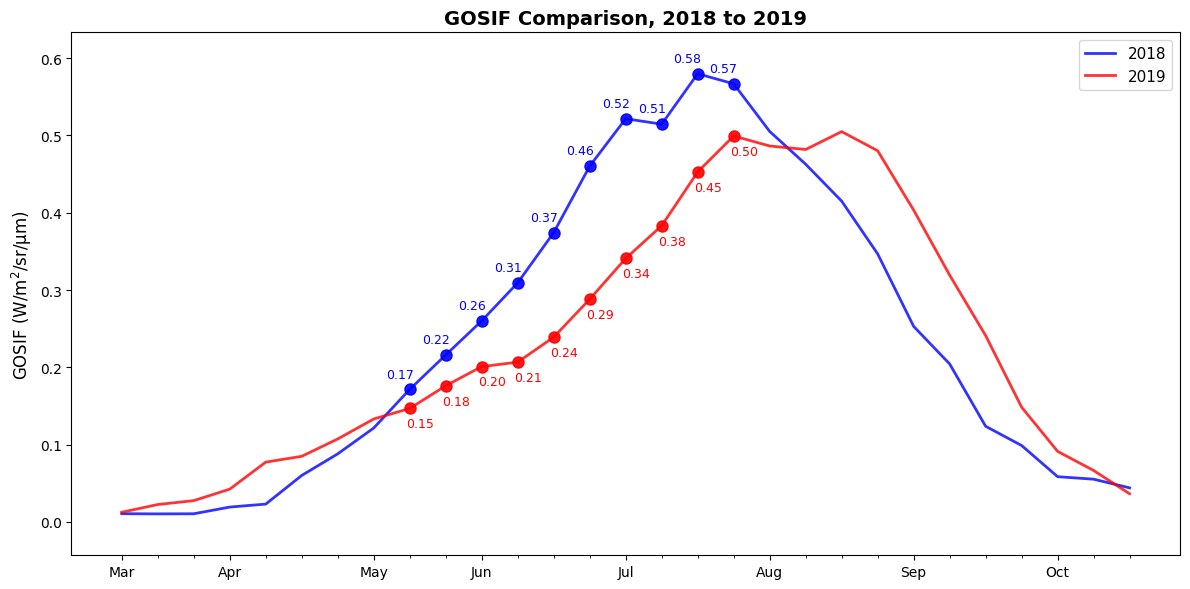

In [3]:
# This is a geojson file from GIS software, you can draw your own shape if you would like to use
# a different region
corn_belt_geojson = "corn_belt.geojson"
data_year_a = []
data_year_b = []
doy_list = []
for date_tuple, gtiff in zip(dates, gosif_geotiffs):
    year = date_tuple[0]
    
    # When setting nodata here, technically we also have to worry about 32766,
    # which is the other special value for ice, but in the case of our region
    # there is no ice to throw off the mean calculation.
    stats = zonal_stats(corn_belt_geojson, gtiff, stats="mean", nodata=32767)
    # the 0-index refers to the mean within the first feature of the geojson file
    zonal_mean = stats[0]["mean"] * gosif_scale_factor
    if year == year_a:
        data_year_a.append(zonal_mean)
        doy_list.append(date_tuple[1])
    elif year == year_b:
        data_year_b.append(zonal_mean)

plot_two_years_comparison(
    doy_list,
    data_year_a,
    year_a,
    data_year_b,
    year_b,
    ylabel="GOSIF (W/m$^2$/sr/μm)",
    title=f"GOSIF Comparison, {year_a} to {year_b}",
    highlight_start_idx=8,
    highlight_end_idx=17,
    label_offset=0.02
)

### What information can we observe in this graph?
The January to August period in 2019 was the wettest in the United States in at least 125 years, and the effects of the flooding were already being felt in the Midwest as the start of the growing season. Starting in late April when corn is typically planted, we can see the GOSIF values for 2018 (the blue line) begin to diverge from the 2019 SIF (red line) over the same region. SIF activity in 2019 continued to be suppressed through the middle of the growing season in July and August, but was partially compensated for by a delayed peak in late August/September. According to Yin et al., this delayed peak can be explained by farmers delaying the date when they planted their crops by up to 5 weeks compared to 2018 due to the waterlogged soil, consquently also delaying the harvest. Overall, the study estimated a 0.21 PgC reduction in primary production for corn and soy crops, equivalent to about a 15% reduction in crop yields for the year.

Referring back to the animation, you may notice that some regions outside of the highlighted corn belt polygon actually have a stronger SIF signal in 2019 as compared with 2018, particularly the Ozarks region of Missouri. Interestingly, the study noted a 0.04 PgC net gain in gross primary production (GPP) over the 17 midwestern states they analyzed over the period from April to September. Natural vegetation is less sensitive to the disruption caused by the flooding and therefore compensated for the reduced growth in cropland areas.